## I/O System Demo for  GeoidIO and SSHIO

### Import GeoidIO from gocean

In [1]:
import copy
from importlib import reload

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from gocean.io.geoid import GeoidIO

### Set the data directory for GeoidIO and read the .gdf file

In [2]:
# cdict = {
#   'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
#   'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
#   'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
# }
#
# cm = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

In [3]:
# Set the data directory to GeoidIO
geoid = GeoidIO(data_dir='../../data/altimetry')

# READ required file
geoid.read('geoid.gdf')

### Let's view the data and header for the geoid

In [4]:
# Required header elements
print('header: \n')
for key in geoid.header.keys():
    print(key, ': ', geoid.header[key])

header: 

lat_max :  15.0
lat_min :  10.0
long_min :  84.0
long_max :  89.0
latitude_parallels :  51
longitude_parallels :  51


In [5]:
# Geoid Data
print('Data: \n', geoid.data)


Data: 
       long   lat      geoid
0     84.0  15.0 -84.054799
1     84.1  15.0 -84.002893
2     84.2  15.0 -83.969667
3     84.3  15.0 -83.939793
4     84.4  15.0 -83.895714
...    ...   ...        ...
2596  88.6  10.0 -69.534257
2597  88.7  10.0 -68.885019
2598  88.8  10.0 -68.245560
2599  88.9  10.0 -67.624133
2600  89.0  10.0 -67.027144

[2601 rows x 3 columns]


### Create a Geoid grid and visualize

In [6]:
# Create geoid grid
geoid.create_geoid_grid()

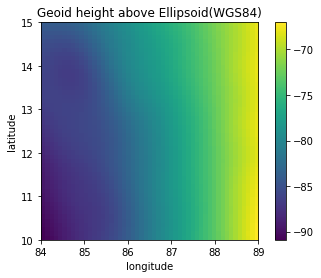

In [7]:
plt.imshow(geoid.grid[:, :, 2], extent=[geoid.header['long_min'],
                                        geoid.header['long_max'],
                                        geoid.header['lat_min'],
                                        geoid.header['lat_max']])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Geoid height above Ellipsoid(WGS84)')

plt.colorbar()
plt.savefig('geoid.png')
plt.show()

### Import SSHIO from gocean

In [8]:
from gocean.io.altimetry import SSHIO

### Set the data directory for jason and saral data

In [9]:
jason = SSHIO('../../data/altimetry')

### Read the SSH data and fill the similar grid as geoid

In [10]:
jason.read(geoid.grid)

### Visualize SSH from Jason and SARAL

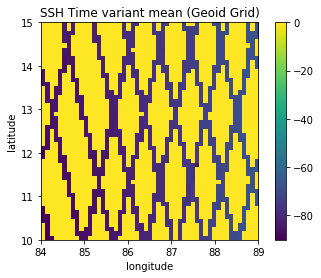

In [11]:
plt.imshow(jason.grid[:, :, 1], extent=[geoid.header['long_min'],
                                        geoid.header['long_max'],
                                        geoid.header['lat_min'],
                                        geoid.header['lat_max']])

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('SSH Time variant mean (Geoid Grid)')

plt.colorbar()

plt.savefig('ssh-tvm.png')
plt.show()

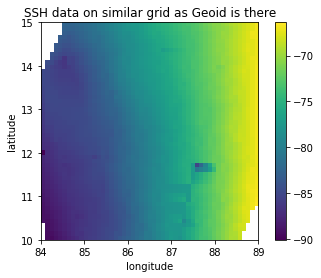

In [12]:
# plt.imshow(geoid.grid[:, :, 2], extent=[geoid.header['long_min'],
#                                         geoid.header['long_max'],
#                                         geoid.header['lat_min'],
#                                         geoid.header['lat_max']])
plt.imshow(jason.grid_filled[:, :], extent=[geoid.header['long_min'],
                                        geoid.header['long_max'],
                                        geoid.header['lat_min'],
                                        geoid.header['lat_max']])

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('SSH data on similar grid as Geoid is there')

plt.colorbar()

plt.savefig('ssh.png')
plt.show()

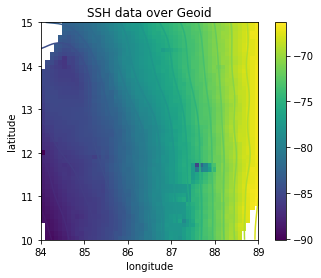

In [13]:
plt.contour(geoid.grid[:, :, 1], geoid.grid[:, :, 0],
            geoid.grid[:, :, 2], extent=[geoid.header['long_min'],
                                        geoid.header['long_max'],
                                        geoid.header['lat_min'],
                                        geoid.header['lat_max']], levels=20)
plt.imshow(jason.grid_filled[:, :], extent=[geoid.header['long_min'],
                                        geoid.header['long_max'],
                                        geoid.header['lat_min'],
                                        geoid.header['lat_max']])

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('SSH data over Geoid')

plt.colorbar()

plt.savefig('ssh-geoid.png')
plt.show()


### Import mdt from gocean.currents module

In [14]:
from gocean.currents.mdt import mdt

In [15]:
mdt_grid = mdt(geoid.grid[:, :, 2], jason.grid_filled)

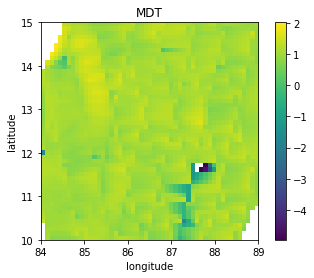

/home/shivam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


In [36]:
plt.imshow(mdt_grid, extent=[geoid.header['long_min'],
                             geoid.header['long_max'],
                             geoid.header['lat_min'],
                             geoid.header['lat_max']])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('MDT')

plt.colorbar()

plt.savefig('mdt.png')
plt.show()

jason.mask[np.where(mdt_grid<-2)] = True

In [37]:
mdt_grid[jason.mask] = np.nan

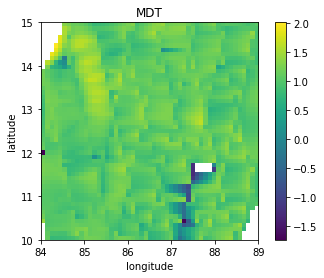

In [38]:
plt.imshow(mdt_grid, extent=[geoid.header['long_min'],
                             geoid.header['long_max'],
                             geoid.header['lat_min'],
                             geoid.header['lat_max']])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('MDT')

plt.colorbar()

plt.savefig('mdt_outl.png')
plt.show()

### Import filtering utility

In [39]:
from gocean.preprocessing.filters import gaussian

In [40]:
mdt_final = copy.copy(mdt_grid)
mdt_final[jason.mask] = 0

In [44]:
mdt_filtered = gaussian(mdt_final, jason.mask, 1)

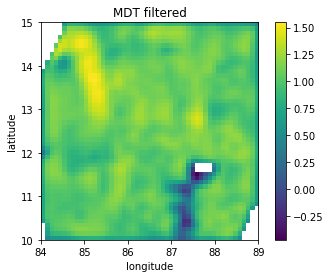

In [45]:
plt.imshow(mdt_filtered, extent=[geoid.header['long_min'],
                             geoid.header['long_max'],
                             geoid.header['lat_min'],
                             geoid.header['lat_max']])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('MDT filtered')

plt.colorbar()

plt.savefig('mdt-filtered.png')
plt.show()


In [46]:
from gocean.currents.current import decompose

In [47]:
u, v = decompose(mdt_final, geoid.grid[:, :, :2])

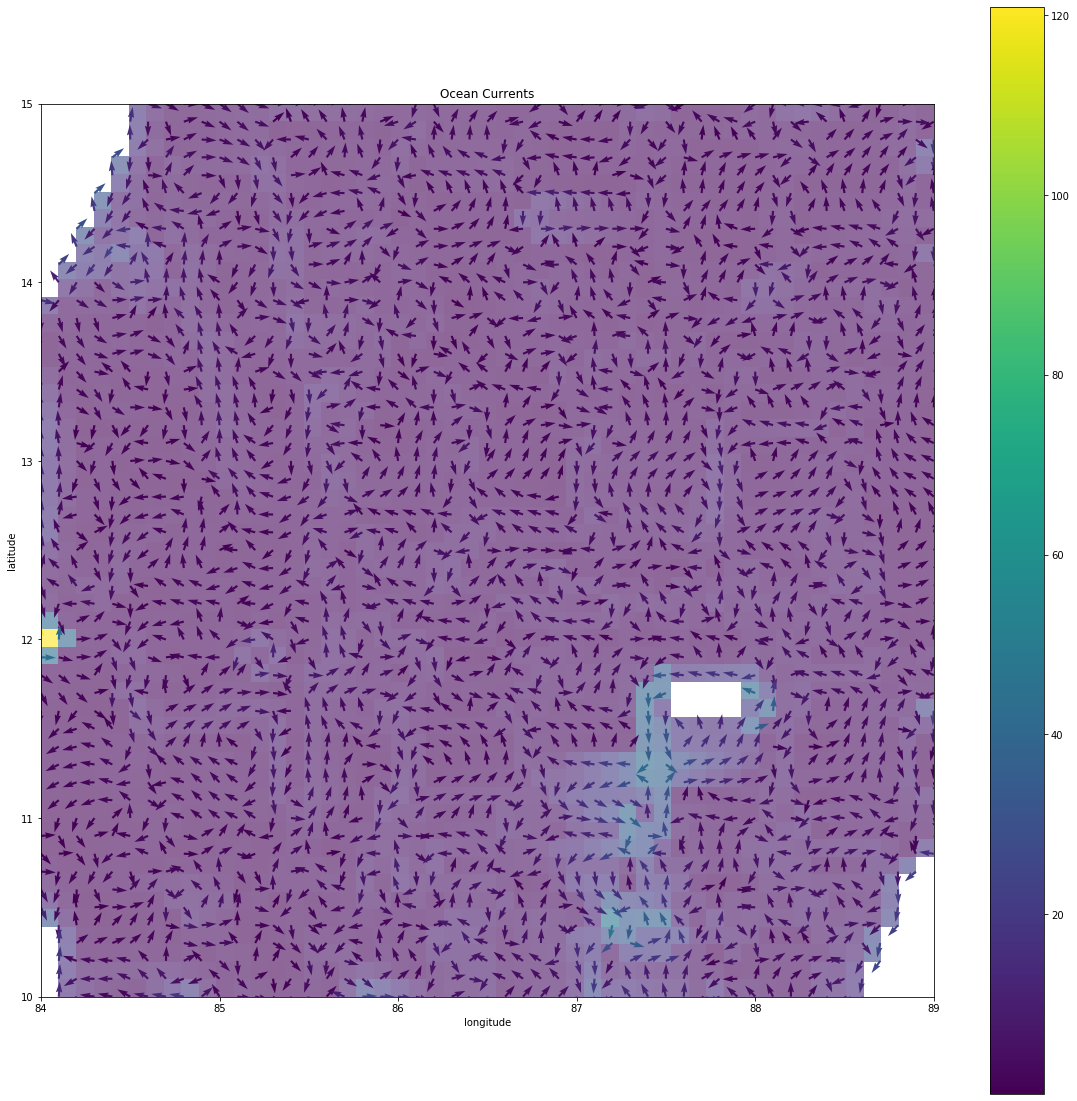

In [48]:
u[jason.mask] = np.nan
v[jason.mask] = np.nan

w = 20
h = 20
fig = plt.figure(figsize=(w,h))

# [10:30, 10:30]
plt.imshow(np.sqrt(u**2+v**2),
           extent=[geoid.header['long_min'],
                 geoid.header['long_max'],
                 geoid.header['lat_min'],
                 geoid.header['lat_max']], alpha=0.6)

plt.quiver(geoid.grid[:, :, 1], geoid.grid[:, :, 0],
           v/np.sqrt(u**2+v**2), -u/np.sqrt(u**2+v**2),
           np.sqrt(u**2+v**2), scale=60)

plt.colorbar()
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Ocean Currents')

plt.savefig('currents-overall.png')
plt.show()

In [113]:
row_block = 50
col_block = 50
for row in np.arange(0, 177, row_block):
    for col in np.arange(0, 210, col_block):
        row_begin = row
        row_end = row_begin+row_block
        if row_end > 177:
            row_end = 177

        col_begin = col
        col_end = col_begin+col_block
        if col_end > 177:
            col_end = 177
        plt.quiver(geoid.grid[row_begin:row_end, col_begin:col_end, 1],
                   geoid.grid[row_begin:row_end, col_begin:col_end, 0],
                   v[row_begin:row_end, col_begin:col_end],
                   u[row_begin:row_end, col_begin:col_end],
                   np.sqrt(u[row_begin:row_end, col_begin:col_end]**2+v[row_begin:row_end, col_begin:col_end]**2))
        plt.colorbar()

        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.title('Ocean Currents')

        plt.savefig('currents/current'+str(row)+str(col)+'.png')
        plt.close()

/home/shivam/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:696: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/shivam/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:696: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/shivam/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:748: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/home/shivam/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:762: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength
/home/shivam/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:680: RuntimeWarning: Mean of empty slice.
  amean = a.mean()
/home/shivam/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars

### Plot currents as unit vector and magnitude

In [49]:
mag = np.sqrt(u**2+v**2)
mag[jason.mask] = -1
mag[np.where(mag>90)] = -1
#
v_unit = copy.copy(v)
u_unit = copy.copy(u)

v_unit[jason.mask] = 0
u_unit[jason.mask] = 0

tmp_mask = np.invert(np.isclose(mag, -1))
# print(tmp_mask)
v_unit[tmp_mask] = v_unit[tmp_mask]/mag[tmp_mask]
u_unit[tmp_mask] = u_unit[tmp_mask]/mag[tmp_mask]
mag /= np.max(mag)

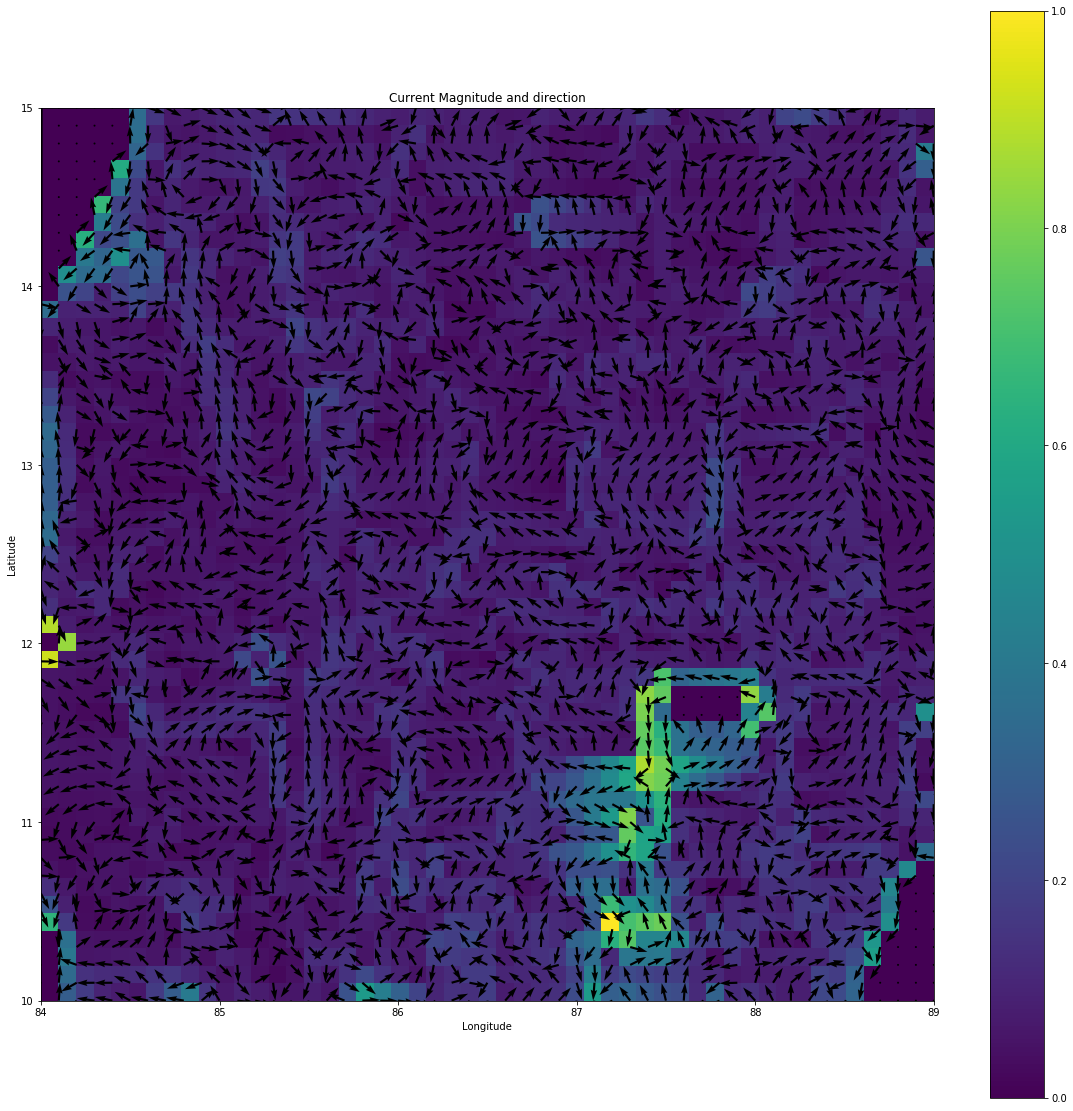

In [53]:
fig = plt.figure(figsize=(w, h))
plt.imshow(mag, extent=[geoid.header['long_min'],
                             geoid.header['long_max'],
                             geoid.header['lat_min'],
                             geoid.header['lat_max']])
plt.quiver(geoid.grid[:, :, 1], geoid.grid[:, :, 0], v_unit, -u_unit, scale=50)
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.title('Current Magnitude and direction')
plt.savefig('Current-Components-with-mag.png')
plt.show()

In [54]:
# modeling
from sklearn.cluster import KMeans

In [55]:
curr = np.zeros([geoid.grid.shape[0], geoid.grid.shape[1], 3])
curr[:, :, 0] = mag
curr[:, :, 1] = v_unit
curr[:, :, 2] = -u_unit
# curr[:, :, 3:] = geoid.grid[:, :, :2]

In [56]:
X = np.reshape(curr, newshape=[geoid.grid.shape[0]*geoid.grid.shape[1], 3])

kmeans = KMeans(n_clusters = 3,
                n_jobs = -1,
                random_state = 123).fit(X)
kmeans_df = pd.DataFrame(kmeans.cluster_centers_, columns = ['Magnitude', 'Longitude Direction', 'Latitude Direction'])

In [57]:
kmeans_df

,Magnitude,Longitude Direction,Latitude Direction
0,0.091678,-0.429854,-0.378194
1,-0.020844,0.142319,120.969638
2,0.087762,0.444977,0.539205


In [58]:
import webcolors

In [59]:
def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]
def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
    return closest_name
kmeans_df["Color Name"] = list(map(get_colour_name, np.uint8(kmeans.cluster_centers_[:, :3])))
kmeans_df

,Magnitude,Longitude Direction,Latitude Direction,Color Name
0,0.091678,-0.429854,-0.378194,black
1,-0.020844,0.142319,120.969638,navy
2,0.087762,0.444977,0.539205,black


In [60]:
def replaceWithCentroid(kmeans):
    new_pixels = []
    for label in kmeans.labels_:
        pixel_as_centroid = list(kmeans.cluster_centers_[label])
        new_pixels.append(pixel_as_centroid)
    new_pixels = np.array(new_pixels).reshape(geoid.grid.shape[0]*geoid.grid.shape[1], -1)
    return new_pixels
new_pixels = replaceWithCentroid(kmeans)

In [61]:
new_pixels

array([[ 0.09167836, -0.4298545 , -0.37819426],
       [ 0.09167836, -0.4298545 , -0.37819426],
       [ 0.09167836, -0.4298545 , -0.37819426],
       ...,
       [ 0.09167836, -0.4298545 , -0.37819426],
       [ 0.09167836, -0.4298545 , -0.37819426],
       [ 0.09167836, -0.4298545 , -0.37819426]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


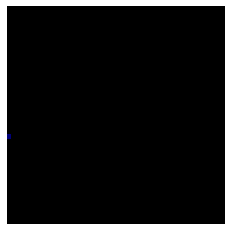

In [62]:
def plotImage(img_array, size):
    reload(plt)
    plt.imshow(np.array(img_array/255).reshape([geoid.grid.shape[0],
                                               geoid.grid.shape[1], 3])[:, :, :3])
    plt.axis('off')
    return plt

plotImage(new_pixels, new_pixels.shape).show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


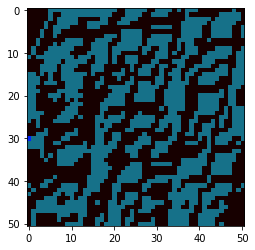

In [63]:
plt.imshow(new_pixels.reshape([geoid.grid.shape[0],
                                               geoid.grid.shape[1], 3]))
plt.savefig('k-means.png')
plt.show()